In [3]:
! pip install pytorch_metric_learning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.1/119.1 kB 3.0 MB/s eta 0:00:00a 0:00:01


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18
from torch.utils.data import DataLoader, random_split, WeightedRandomSampler
import numpy as np
import matplotlib.pyplot as plt
from cleverhans.torch.attacks.fast_gradient_method import fast_gradient_method
from umap.umap_ import UMAP
import random
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from pytorch_metric_learning import losses

2024-04-12 20:59:30.686746: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-12 20:59:30.686866: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-12 20:59:30.829495: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
# Set global parameters
num_epochs = 10

device = torch.device("cuda" if torch.cuda.is_available() else "mps")
if device == 'cuda':
    model = torch.nn.DataParallel(model)
    cudnn.benchmark = True

print(device)

cuda


### Data loaders

In [6]:
# Load and preprocess CIFAR10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Define the size for the train and validation splits
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Calculate the class weights
class_counts = [0] * 10  # 10 classes in CIFAR10
for _, label in train_dataset:
    class_counts[label] += 1

total_samples = sum(class_counts)
class_weights = [total_samples / count for count in class_counts]
# Create a list of sample weights based on class weights
sample_weights = [class_weights[label] for _, label in train_dataset]
# Create a WeightedRandomSampler
sampler = WeightedRandomSampler(sample_weights, num_samples=len(train_dataset), replacement=True)

# Create data loaders for training, validation, and test
train_loader = DataLoader(train_dataset, batch_size=128, sampler=sampler, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, drop_last=True)

100%|██████████| 170498071/170498071 [00:02<00:00, 64639318.02it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### Checking distribution of data

In [7]:
# Check class distribution in each batch
num_classes = 10  # Assuming 10 classes in CIFAR10
batch_class_counts = [0] * num_classes

for batch_images, batch_labels in train_loader:
    for label in batch_labels:
        batch_class_counts[label] += 1

    # Reset batch class counts for the next batch
    batch_class_counts = [0] * num_classes

# Print overall class distribution in the training dataset
print("\nOverall class distribution in the training dataset:")
for i, count in enumerate(class_counts):
    print(f"Class {i}: {count}")


Overall class distribution in the training dataset:
Class 0: 4015
Class 1: 4041
Class 2: 4019
Class 3: 3987
Class 4: 3979
Class 5: 3996
Class 6: 3997
Class 7: 3954
Class 8: 4010
Class 9: 4002


# Help functions

### KNN test function

In [8]:
# Extract features from the images using the pre-trained model
def extract_features(model, dataloader):
    model.eval()
    features = []
    labels = []
    with torch.no_grad():
        for images, targets in dataloader:
            images = images.cuda()
            features_batch = model(images).cpu().numpy()
            features.append(features_batch)
            labels.append(targets.numpy())
    features = np.concatenate(features)
    labels = np.concatenate(labels)
    return features, labels



# Test the model on original test data using KNN
def test_model_knn(model, knn_classifier, dataloader):
    model.eval()
    features, labels = extract_features(model, dataloader)
    predicted_labels = knn_classifier.predict(features)
    accuracy = accuracy_score(labels, predicted_labels) * 100
    print(f"Accuracy on original test data using KNN: {accuracy:.2f}%")



# Test the model on adversarial test data using KNN
def test_model_adversarial_knn(model, knn_classifier, adversarial_images, labels, device):
    model.eval()
    # Convert adversarial_images to tensor
    adversarial_images_tensor = torch.tensor(adversarial_images, dtype=torch.float32).to(device)
    # Detach the tensor from the computation graph
    features = model(adversarial_images_tensor).detach().cpu().numpy()
    predicted_labels = knn_classifier.predict(features)
    accuracy = accuracy_score(labels, predicted_labels) * 100
    print(f"Accuracy on adversarial test data using KNN: {accuracy:.2f}%")

### Visualize feature map

In [9]:
def plot_umap(model, dataloader, device):
    # Set model to evaluation mode
    model.eval()

    # Define a function to get embeddings
    def get_embeddings(model, dataloader):
        embeddings = []
        labels = []
        with torch.no_grad():
            for images, targets in dataloader:
                images = images.to(device)
                outputs = model(images)
                embeddings.append(outputs.cpu().numpy())
                labels.append(targets.cpu().numpy())
        embeddings = np.concatenate(embeddings)
        labels = np.concatenate(labels)
        return embeddings, labels

    # Get embeddings from the dataloader
    embeddings_test, labels_test = get_embeddings(model, dataloader)

    # Use UMAP to reduce dimensionality
    reducer = UMAP()
    embedding_umap_test = reducer.fit_transform(embeddings_test)

    # Plot UMAP visualization
    plt.figure(figsize=(8, 6))
    plt.scatter(embedding_umap_test[:, 0], embedding_umap_test[:, 1], c=labels_test, cmap='viridis')
    plt.colorbar(label='Class')
    plt.title('UMAP Visualization of original data')
    plt.xlabel('UMAP Dimension 1')
    plt.ylabel('UMAP Dimension 2')
    plt.show()

### Generate adverserial samples

In [10]:
def combine_fgsm_and_noise(model, images, labels, eps, noise_factor):
    # Generate adversarial images using CleverHans's Fast Gradient Sign Method (FGSM)
    attack_images = fast_gradient_method(model, images, eps, np.inf, targeted=False, y=labels)
    attack_images = attack_images.detach()

    # Add Gaussian noise
    attack_images_np = attack_images.cpu().numpy()
    attack_images_np += noise_factor * np.random.normal(loc=0, scale=1, size=attack_images_np.shape)
    attack_images_np = np.clip(attack_images_np, 0, 1)
    attack_images_with_noise = torch.tensor(attack_images_np, requires_grad=False).to(device)

    return attack_images_with_noise

# Parameters for FGSM and noise
eps = 0.1
noise_factor = 0.05

# 1. Original dataset/Cross Entropy

### 1.1. Train original data/Cross entropy

In [11]:
def train(model, train_loader, val_loader, criterion, optimizer, device, epochs):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            train_total += labels.size(0)

        # Validation phase
        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        # Calculate average losses
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)

        # Append to lists
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        # Print training and validation loss
        print(f"Epoch [{epoch+1}/{epochs}], "
              f"Training Loss: {train_loss:.4f}, "
              f"Validation Loss: {val_loss:.4f}")

    # Plot training and validation loss
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, epochs + 1), train_losses, marker='o', label='Training Loss')
    plt.plot(range(1, epochs + 1), val_losses, marker='s', label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss vs. Epoch')
    plt.legend()
    plt.show()

    return train_losses, val_losses

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 118MB/s] 


Epoch [1/10], Training Loss: 0.8615, Validation Loss: 1.0162
Epoch [2/10], Training Loss: 0.5438, Validation Loss: 0.7194
Epoch [3/10], Training Loss: 0.4152, Validation Loss: 0.6494
Epoch [4/10], Training Loss: 0.3299, Validation Loss: 0.6833
Epoch [5/10], Training Loss: 0.2662, Validation Loss: 0.6896
Epoch [6/10], Training Loss: 0.2143, Validation Loss: 0.7205
Epoch [7/10], Training Loss: 0.1803, Validation Loss: 0.7626
Epoch [8/10], Training Loss: 0.1596, Validation Loss: 0.7387
Epoch [9/10], Training Loss: 0.1326, Validation Loss: 0.8090
Epoch [10/10], Training Loss: 0.1227, Validation Loss: 0.7980


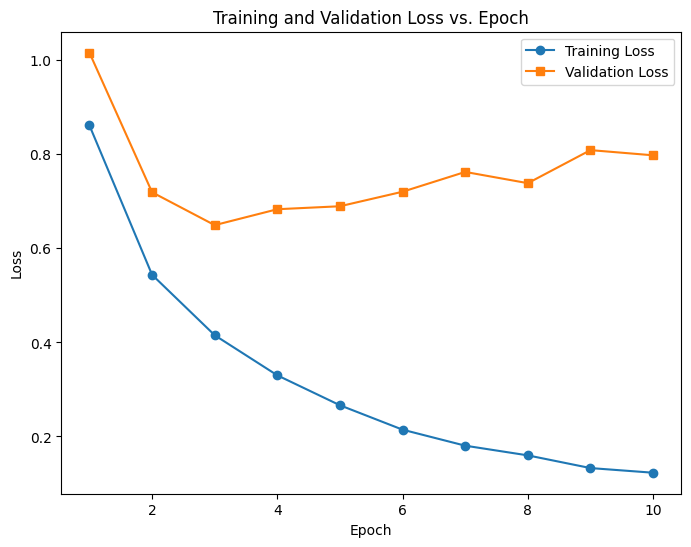

In [12]:
# Setup
model = resnet18(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 10)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train
train_losses = train(model, train_loader, val_loader, criterion, optimizer, device, num_epochs)

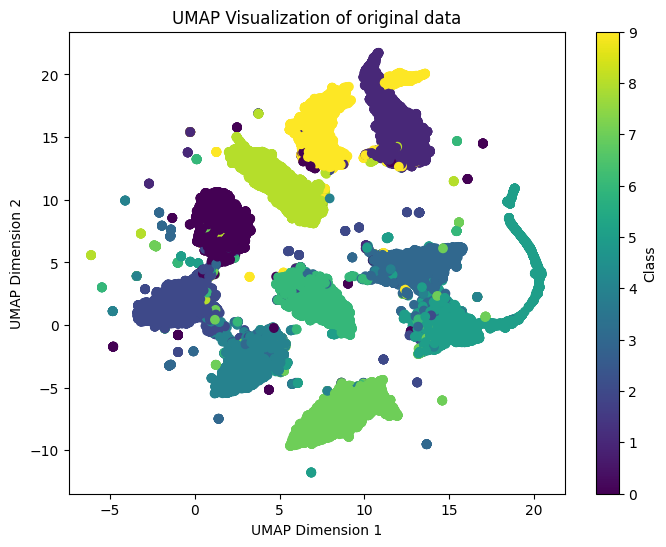

In [13]:
# Call the function to extract and visualize features
plot_umap(model, train_loader, device)

### 1.2. FGSM

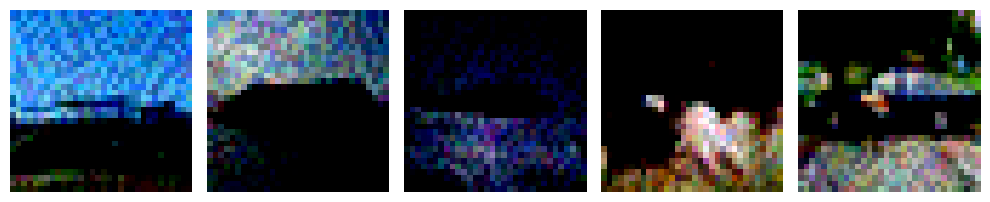

In [14]:
model.eval()
adversarial_images = []
original_images = []
labels = []

for images, targets in val_loader:
    images, targets = images.to(device), targets.to(device)
    images_with_attack = combine_fgsm_and_noise(model, images, targets, eps, noise_factor).detach().cpu().numpy()
    adversarial_images.append(images_with_attack)
    original_images.append(images.detach().cpu().numpy())
    labels.append(targets.detach().cpu().numpy())

# Convert lists to numpy arrays
adversarial_images = np.concatenate(adversarial_images)
original_images = np.concatenate(original_images)
labels = np.concatenate(labels)

# Display some adversarial images
num_images = 5
indices = np.random.choice(len(adversarial_images), num_images, replace=False)
plt.figure(figsize=(10, 4))
for i, index in enumerate(indices):
    plt.subplot(1, num_images, i+1)
    plt.imshow(np.transpose(adversarial_images[index], (1, 2, 0)))
    plt.axis('off')
plt.tight_layout()
plt.show()

### 1.3. Test original data/Cross entropy

In [15]:
train_features, train_labels = extract_features(model, train_loader)

# Train KNN classifier
knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(train_features, train_labels)

test_model_knn(model, knn_classifier, test_loader)
test_model_adversarial_knn(model, knn_classifier, adversarial_images, labels, device)

Accuracy on original test data using KNN: 80.12%
Accuracy on adversarial test data using KNN: 10.12%


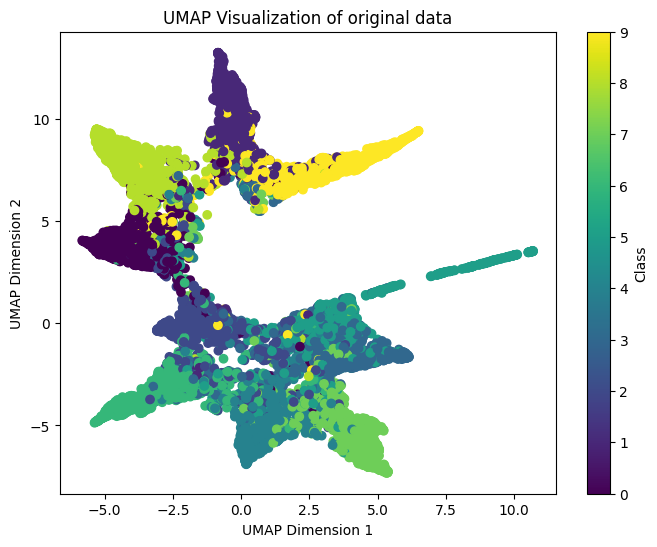

In [16]:
# Call the function to extract and visualize features
plot_umap(model, test_loader, device)

# 2. Agumented data/Cross entropy

### 2.1. Train agumented data/Cross entropy

In [17]:
# Function to apply FGSM attack with 50% probability to each batch
def apply_fgsm(model, images, labels, criterion, eps):
    # Enable gradients for images
    images.requires_grad = True

    # Perform FGSM attack only if gradients are enabled
    if images.requires_grad:
        outputs = model(images)
        model.zero_grad()
        cost = criterion(outputs, labels)
        cost.backward()
        attack_images = images + eps * images.grad.sign()
        attack_images = torch.clamp(attack_images, 0, 1)
    else:
        attack_images = images

    return attack_images

In [18]:
# Modified training function to apply FGSM with 50% probability
def train_with_fgsm(model, train_loader, val_loader, criterion, optimizer, device, epochs, eps=0.1):
    train_losses = []
    val_losses = []
    for epoch in range(epochs):
        model.train()
        train_epoch_loss = 0.0
        # Training loop
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            
            # Apply FGSM attack with 50% probability
            if torch.rand(1) < 0.5:
                images = apply_fgsm(model, images, labels, criterion, eps)

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_epoch_loss += loss.item()
        train_epoch_loss /= len(train_loader)
        train_losses.append(train_epoch_loss)

        # Validation loop
        model.eval()
        val_epoch_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                
                # Note: No FGSM attack is applied during validation
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_epoch_loss += loss.item()
        val_epoch_loss /= len(val_loader)
        val_losses.append(val_epoch_loss)

        # Print training and validation loss
        print(f"Epoch [{epoch+1}/{epochs}], Training Loss: {train_epoch_loss:.4f}, Validation Loss: {val_epoch_loss:.4f}")

    # Plot training and validation loss
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, epochs + 1), train_losses, 'o-', label='Training Loss')
    plt.plot(range(1, epochs + 1), val_losses, 's-', label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss vs. Epoch')
    plt.legend()
    plt.show()

    return train_losses, val_losses

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10], Training Loss: 1.4430, Validation Loss: 0.9955
Epoch [2/10], Training Loss: 1.1532, Validation Loss: 0.8675
Epoch [3/10], Training Loss: 0.9795, Validation Loss: 0.7874
Epoch [4/10], Training Loss: 0.8550, Validation Loss: 0.7934
Epoch [5/10], Training Loss: 0.8740, Validation Loss: 0.6962
Epoch [6/10], Training Loss: 0.7975, Validation Loss: 0.6932
Epoch [7/10], Training Loss: 0.6820, Validation Loss: 0.7545
Epoch [8/10], Training Loss: 0.6503, Validation Loss: 0.7611
Epoch [9/10], Training Loss: 0.6223, Validation Loss: 0.7213
Epoch [10/10], Training Loss: 0.6049, Validation Loss: 0.6872


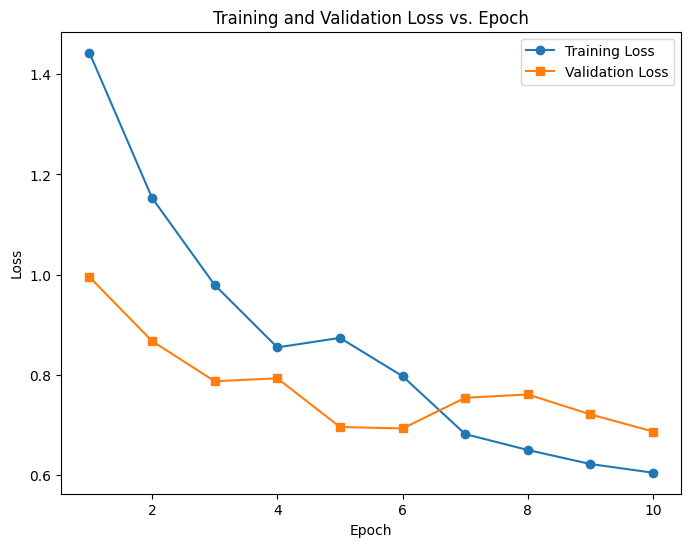

In [19]:
# Setup and Retrain
new_model = resnet18(pretrained=True)
num_features = new_model.fc.in_features
new_model.fc = nn.Linear(num_features, 10)
new_model = new_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(new_model.parameters(), lr=0.001)

# Train
train_losses = train_with_fgsm(new_model, train_loader, val_loader, criterion, optimizer, device, num_epochs)

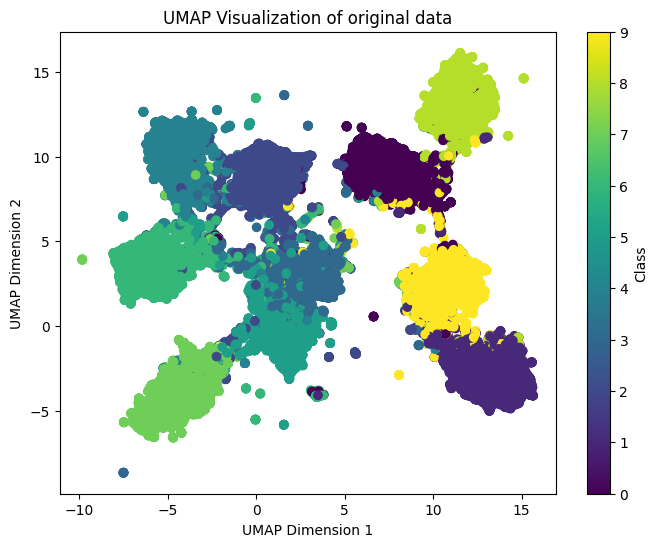

In [20]:
# Call the function to extract and visualize features
plot_umap(new_model, train_loader, device)

### 2.2. FGSM

In [21]:
new_model.eval()
adversarial_images = []
original_images = []
labels = []

for images, targets in val_loader:
    images, targets = images.to(device), targets.to(device)
    images_with_attack = combine_fgsm_and_noise(new_model, images, targets, eps, noise_factor).detach().cpu().numpy()
    adversarial_images.append(images_with_attack)
    original_images.append(images.detach().cpu().numpy())
    labels.append(targets.detach().cpu().numpy())

# Convert lists to numpy arrays
adversarial_images = np.concatenate(adversarial_images)
original_images = np.concatenate(original_images)
labels = np.concatenate(labels)

### 2.3. Test agumented data/Cross entropy

In [22]:
# KNN test
train_features, train_labels = extract_features(new_model, train_loader)

# Train KNN classifier
knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(train_features, train_labels)

test_model_knn(new_model, knn_classifier, test_loader)
test_model_adversarial_knn(new_model, knn_classifier, adversarial_images, labels, device)

Accuracy on original test data using KNN: 77.21%
Accuracy on adversarial test data using KNN: 22.79%


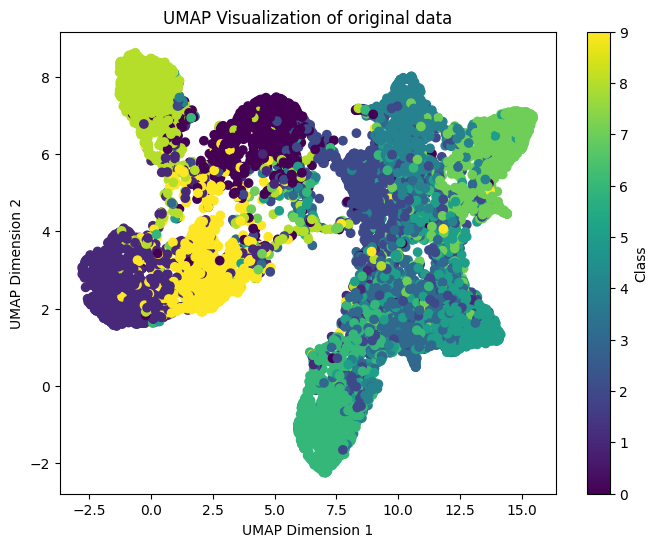

In [23]:
# Call the function to extract and visualize features
plot_umap(new_model, test_loader, device)

# 3. Original data/Circle loss

### 3.1. Optimum values of the Circle loss

In [24]:
def train(model, train_loader, val_loader, criterion, optimizer, device, epochs):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            embeddings = model(images)
            loss = criterion(embeddings, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            train_total += labels.size(0)

        # Validation phase
        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                embeddings = model(images)
                loss = criterion(embeddings, labels)
                val_loss += loss.item()

        # Calculate average losses
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)

        # Append to lists
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        # Print training and validation loss
        print(f"Epoch [{epoch+1}/{epochs}], "
              f"Training Loss: {train_loss:.4f}, "
              f"Validation Loss: {val_loss:.4f}")

    # Plot training and validation loss
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, epochs + 1), train_losses, marker='o', label='Training Loss')
    plt.plot(range(1, epochs + 1), val_losses, marker='s', label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss vs. Epoch')
    plt.legend()
    plt.show()

    return train_losses, val_losses

In [28]:
def greedy_search(model, train_loader, val_loader, criterion, optimizer, device, num_epochs, m_values, gamma_values):
    best_accuracy = 0.0
    best_m = None
    best_gamma = None

    for m in m_values:
        for gamma in gamma_values:
            criterion = losses.CircleLoss(m=m, gamma=gamma)
            optimizer = optim.Adam(model.parameters(), lr=0.001)
            train_losses, val_losses = train(model, train_loader, val_loader, criterion, optimizer, device, num_epochs)
            accuracy = calculate_accuracy(model, val_loader, device)  # You need to define this function
            print(f"m={m}, gamma={gamma}, Validation Accuracy: {accuracy}")

            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_m = m
                best_gamma = gamma

    print(f"Best m={best_m}, gamma={best_gamma}, Best Validation Accuracy: {best_accuracy}")
    

    
def calculate_accuracy(model, dataloader, device):
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total



Epoch [1/10], Training Loss: 17.5205, Validation Loss: 70.9643
Epoch [2/10], Training Loss: 16.3478, Validation Loss: 76.1620
Epoch [3/10], Training Loss: 15.8130, Validation Loss: 74.2126
Epoch [4/10], Training Loss: 14.8505, Validation Loss: 77.0705
Epoch [5/10], Training Loss: 14.4251, Validation Loss: 74.4672
Epoch [6/10], Training Loss: 13.7861, Validation Loss: 74.8976
Epoch [7/10], Training Loss: 13.5696, Validation Loss: 74.8605
Epoch [8/10], Training Loss: 13.5219, Validation Loss: 76.6263
Epoch [9/10], Training Loss: 12.9202, Validation Loss: 75.1053
Epoch [10/10], Training Loss: 12.4531, Validation Loss: 77.2204


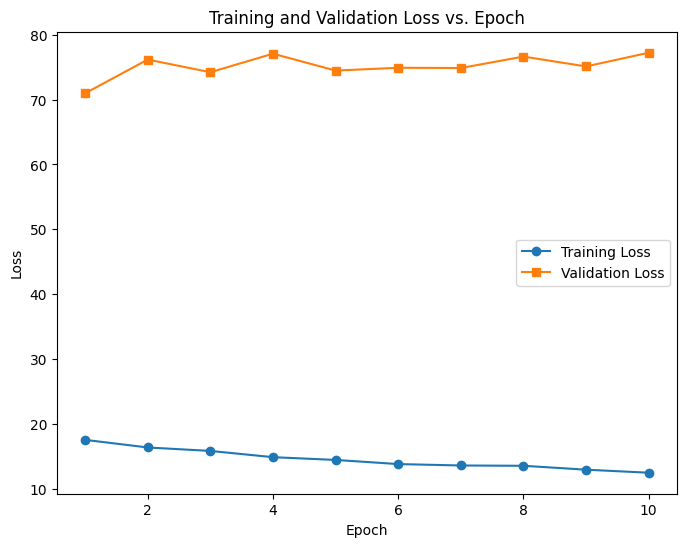

m=0.2, gamma=50, Validation Accuracy: 0.796875
Epoch [1/10], Training Loss: 17.1968, Validation Loss: 125.4506
Epoch [2/10], Training Loss: 16.5073, Validation Loss: 127.2759
Epoch [3/10], Training Loss: 17.4943, Validation Loss: 131.8670
Epoch [4/10], Training Loss: 17.1709, Validation Loss: 127.9461
Epoch [5/10], Training Loss: 15.6302, Validation Loss: 126.3715
Epoch [6/10], Training Loss: 14.6410, Validation Loss: 125.5379
Epoch [7/10], Training Loss: 15.4296, Validation Loss: 122.9466
Epoch [8/10], Training Loss: 14.2185, Validation Loss: 125.8148
Epoch [9/10], Training Loss: 14.5493, Validation Loss: 128.5948
Epoch [10/10], Training Loss: 13.9713, Validation Loss: 124.8128


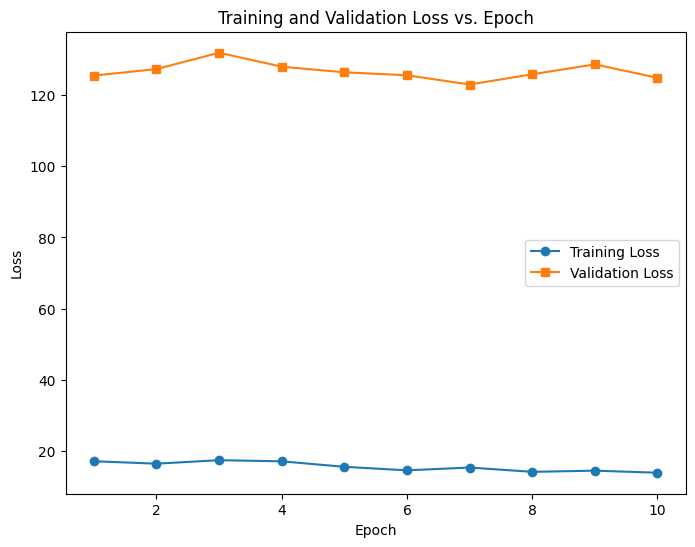

m=0.2, gamma=80, Validation Accuracy: 0.7970753205128205
Epoch [1/10], Training Loss: 16.8420, Validation Loss: 156.9663
Epoch [2/10], Training Loss: 17.2557, Validation Loss: 160.0685
Epoch [3/10], Training Loss: 17.2655, Validation Loss: 161.6312
Epoch [4/10], Training Loss: 14.9831, Validation Loss: 161.6187
Epoch [5/10], Training Loss: 14.6368, Validation Loss: 167.9602
Epoch [6/10], Training Loss: 15.2343, Validation Loss: 160.0996
Epoch [7/10], Training Loss: 14.7617, Validation Loss: 163.5711
Epoch [8/10], Training Loss: 13.8997, Validation Loss: 171.5713
Epoch [9/10], Training Loss: 15.4912, Validation Loss: 159.8085
Epoch [10/10], Training Loss: 12.8318, Validation Loss: 165.2260


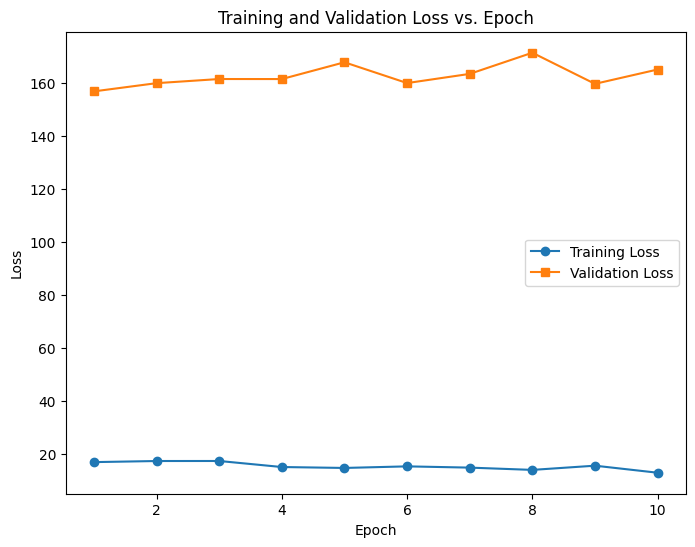

m=0.2, gamma=100, Validation Accuracy: 0.8013822115384616
Epoch [1/10], Training Loss: 2.9244, Validation Loss: 59.0294
Epoch [2/10], Training Loss: 2.3089, Validation Loss: 57.1994
Epoch [3/10], Training Loss: 3.3516, Validation Loss: 57.0297
Epoch [4/10], Training Loss: 2.3852, Validation Loss: 57.8963
Epoch [5/10], Training Loss: 1.9895, Validation Loss: 59.4075
Epoch [6/10], Training Loss: 1.6140, Validation Loss: 60.1280
Epoch [7/10], Training Loss: 2.1135, Validation Loss: 59.6199
Epoch [8/10], Training Loss: 2.0384, Validation Loss: 57.9730
Epoch [9/10], Training Loss: 2.4122, Validation Loss: 58.9096
Epoch [10/10], Training Loss: 2.8720, Validation Loss: 57.9501


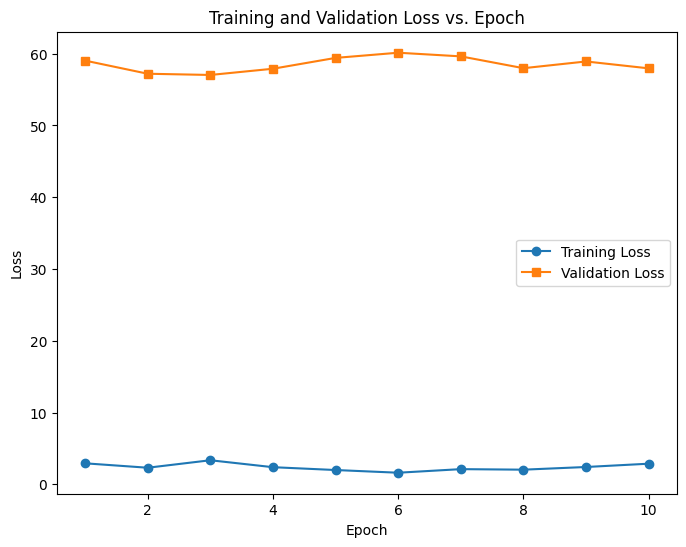

m=0.4, gamma=50, Validation Accuracy: 0.7970753205128205
Epoch [1/10], Training Loss: 3.8817, Validation Loss: 90.0095
Epoch [2/10], Training Loss: 3.0950, Validation Loss: 91.2307
Epoch [3/10], Training Loss: 2.6862, Validation Loss: 89.6756
Epoch [4/10], Training Loss: 2.6851, Validation Loss: 91.7985
Epoch [5/10], Training Loss: 2.9729, Validation Loss: 93.0165
Epoch [6/10], Training Loss: 3.3519, Validation Loss: 93.4774
Epoch [7/10], Training Loss: 2.8543, Validation Loss: 90.4639
Epoch [8/10], Training Loss: 2.3107, Validation Loss: 91.1193
Epoch [9/10], Training Loss: 2.5498, Validation Loss: 93.4308
Epoch [10/10], Training Loss: 2.7050, Validation Loss: 89.6281


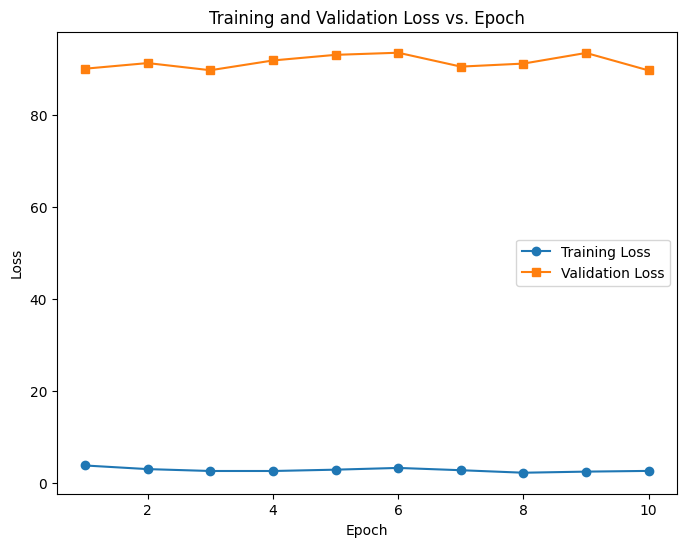

m=0.4, gamma=80, Validation Accuracy: 0.8023838141025641
Epoch [1/10], Training Loss: 3.0586, Validation Loss: 110.9817
Epoch [2/10], Training Loss: 2.9012, Validation Loss: 121.3339
Epoch [3/10], Training Loss: 3.1333, Validation Loss: 114.0965
Epoch [4/10], Training Loss: 2.2152, Validation Loss: 105.1448
Epoch [5/10], Training Loss: 2.3273, Validation Loss: 111.7961
Epoch [6/10], Training Loss: 3.8198, Validation Loss: 113.6531
Epoch [7/10], Training Loss: 3.2394, Validation Loss: 113.7478
Epoch [8/10], Training Loss: 2.6535, Validation Loss: 113.5658
Epoch [9/10], Training Loss: 2.6429, Validation Loss: 114.6467
Epoch [10/10], Training Loss: 3.0501, Validation Loss: 111.5377


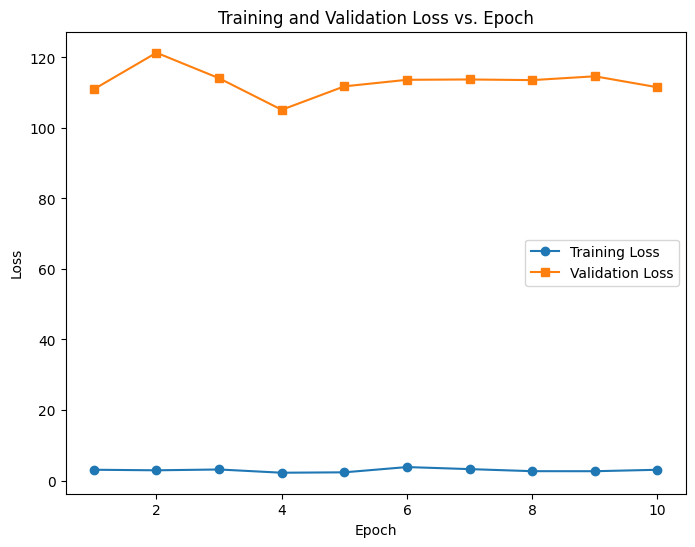

m=0.4, gamma=100, Validation Accuracy: 0.7951722756410257
Epoch [1/10], Training Loss: 0.2763, Validation Loss: 24.8543
Epoch [2/10], Training Loss: 0.1635, Validation Loss: 24.4541
Epoch [3/10], Training Loss: 0.1835, Validation Loss: 24.5034
Epoch [4/10], Training Loss: 0.1485, Validation Loss: 25.8699
Epoch [5/10], Training Loss: 0.3020, Validation Loss: 22.3296
Epoch [6/10], Training Loss: 0.2476, Validation Loss: 21.2312
Epoch [7/10], Training Loss: 0.4503, Validation Loss: 20.5418
Epoch [8/10], Training Loss: 0.1486, Validation Loss: 22.3262
Epoch [9/10], Training Loss: 0.1193, Validation Loss: 23.2570
Epoch [10/10], Training Loss: 0.0673, Validation Loss: 24.0814


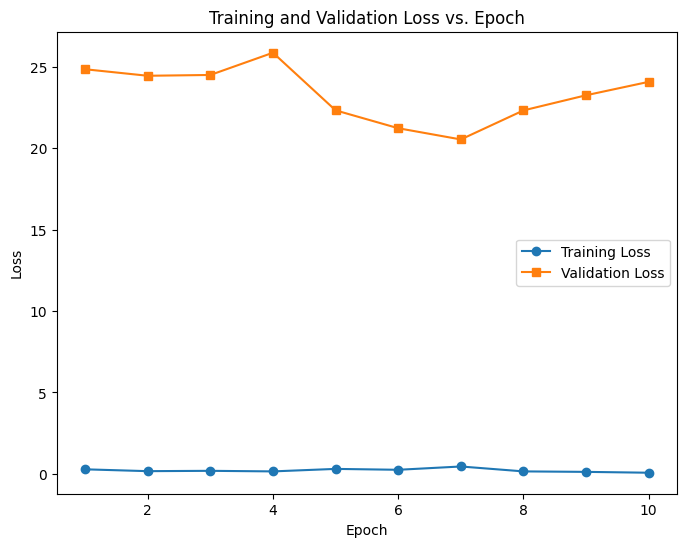

m=0.6, gamma=50, Validation Accuracy: 0.7947716346153846
Epoch [1/10], Training Loss: 0.3841, Validation Loss: 27.9360
Epoch [2/10], Training Loss: 0.0627, Validation Loss: 31.6701
Epoch [3/10], Training Loss: 0.3473, Validation Loss: 31.2448
Epoch [4/10], Training Loss: 0.7606, Validation Loss: 27.4963
Epoch [5/10], Training Loss: 0.1882, Validation Loss: 30.0009
Epoch [6/10], Training Loss: 0.1162, Validation Loss: 28.9183
Epoch [7/10], Training Loss: 0.1682, Validation Loss: 31.9958
Epoch [8/10], Training Loss: 0.6723, Validation Loss: 28.4562
Epoch [9/10], Training Loss: 0.2780, Validation Loss: 27.2173
Epoch [10/10], Training Loss: 0.2943, Validation Loss: 27.6725


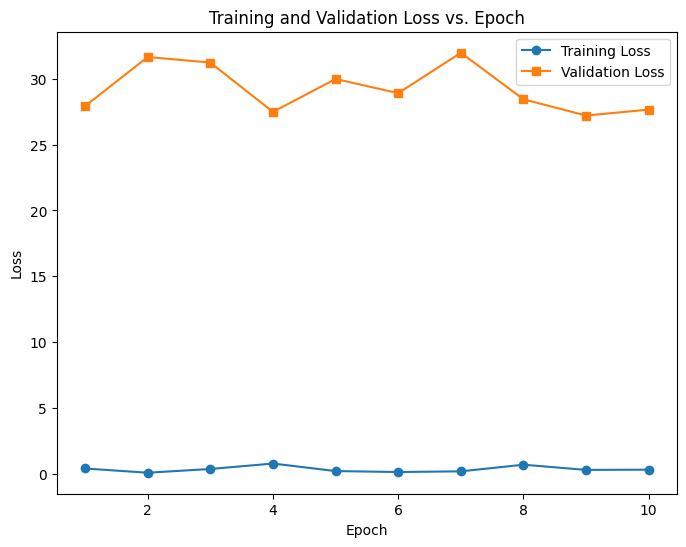

m=0.6, gamma=80, Validation Accuracy: 0.7855568910256411
Epoch [1/10], Training Loss: 0.2788, Validation Loss: 36.4952
Epoch [2/10], Training Loss: 0.4513, Validation Loss: 35.1766
Epoch [3/10], Training Loss: 0.2976, Validation Loss: 34.5408
Epoch [4/10], Training Loss: 0.2083, Validation Loss: 35.9248
Epoch [5/10], Training Loss: 0.1725, Validation Loss: 36.5695
Epoch [6/10], Training Loss: 0.7129, Validation Loss: 32.8376
Epoch [7/10], Training Loss: 0.3101, Validation Loss: 34.4456
Epoch [8/10], Training Loss: 0.3106, Validation Loss: 33.9794
Epoch [9/10], Training Loss: 0.2491, Validation Loss: 32.7140
Epoch [10/10], Training Loss: 0.1010, Validation Loss: 35.6606


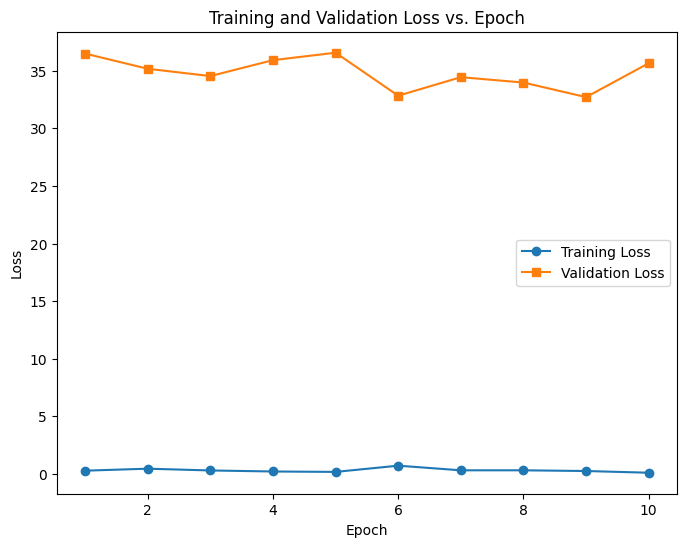

m=0.6, gamma=100, Validation Accuracy: 0.7879607371794872
Best m=0.4, gamma=80, Best Validation Accuracy: 0.8023838141025641


In [29]:
# # Define the search space for m and gamma
# m_values = [0.2, 0.4, 0.6]
# gamma_values = [50, 80, 100]

# # Perform greedy search
# greedy_search(model, train_loader, val_loader, criterion, optimizer, device, num_epochs, m_values, gamma_values)

### 3.2. Train original data/Circle loss

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10], Training Loss: 101.1132, Validation Loss: 102.2839
Epoch [2/10], Training Loss: 100.8308, Validation Loss: 102.1055
Epoch [3/10], Training Loss: 100.6870, Validation Loss: 101.3901
Epoch [4/10], Training Loss: 100.9400, Validation Loss: 101.9838
Epoch [5/10], Training Loss: 100.8063, Validation Loss: 102.1593
Epoch [6/10], Training Loss: 101.0698, Validation Loss: 102.1197
Epoch [7/10], Training Loss: 101.1418, Validation Loss: 101.9060
Epoch [8/10], Training Loss: 100.7376, Validation Loss: 102.0941
Epoch [9/10], Training Loss: 100.8689, Validation Loss: 101.9011
Epoch [10/10], Training Loss: 100.5956, Validation Loss: 102.4404


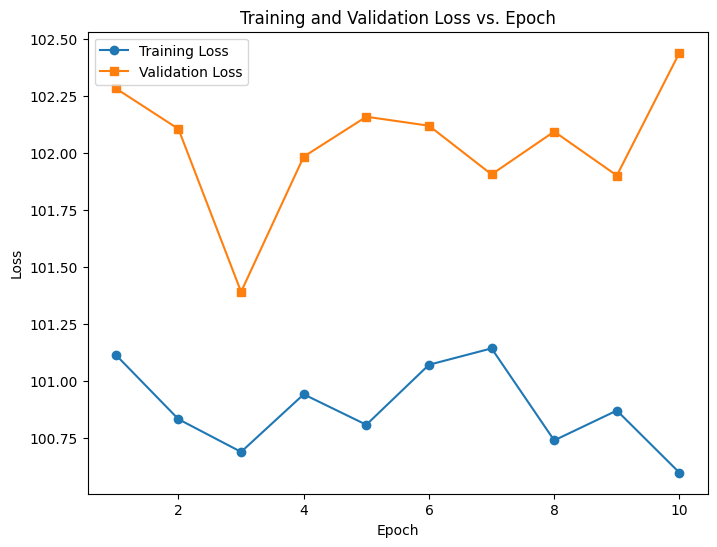

In [30]:
# Setup and Retrain
class EmbeddingModel(nn.Module):
    def __init__(self, backbone):
        super(EmbeddingModel, self).__init__()
        self.backbone = backbone
        self.identity = nn.Identity()

    def forward(self, x):
        features = self.backbone(x)
        embeddings = self.identity(features)
        return embeddings

backbone = resnet18(pretrained=True)
new_model2 = EmbeddingModel(backbone)
new_model2 = new_model2.to(device)

criterion = losses.CircleLoss(m=0.4, gamma=80)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train
train_losses_circle = train(new_model2, train_loader, val_loader, criterion, optimizer, device, num_epochs)

### 3.3. FGSM

In [31]:
new_model2.eval()
adversarial_images = []
original_images = []
labels = []

for images, targets in val_loader:
    images, targets = images.to(device), targets.to(device)
    images_with_attack = combine_fgsm_and_noise(new_model2, images, targets, eps, noise_factor).detach().cpu().numpy()
    adversarial_images.append(images_with_attack)
    original_images.append(images.detach().cpu().numpy())
    labels.append(targets.detach().cpu().numpy())

# Convert lists to numpy arrays
adversarial_images = np.concatenate(adversarial_images)
original_images = np.concatenate(original_images)
labels = np.concatenate(labels)

### 3.4. Test original data/Circle loss

In [32]:
# KNN test
train_features, train_labels = extract_features(new_model2, train_loader)

# Train KNN classifier
knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(train_features, train_labels)


test_model_knn(new_model2, knn_classifier, test_loader)
test_model_adversarial_knn(new_model2, knn_classifier, adversarial_images, labels, device)

Accuracy on original test data using KNN: 28.93%
Accuracy on adversarial test data using KNN: 13.76%


In [ ]:
# Call the function to extract and visualize features
plot_umap(new_model2, test_loader, device)